<a href="https://colab.research.google.com/github/mdrabic5/SSIP-2021-Age-recognition-project/blob/main/SSIP_2021_age_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import os
import itertools

import cv2
from time import time
from google.colab.patches import cv2_imshow
from google.colab import drive

import pandas as pd
pd.set_option('display.max_rows', 15000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)

import numpy as np
from pathlib import Path
import tensorflow as tf

import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

from keras.applications.mobilenet import MobileNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

from keras.layers import Dense, Dropout, Flatten, GlobalMaxPooling2D, BatchNormalization
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.applications import EfficientNetB4

# SSIP 2021 - Age recognition project

Recognizing the age of person based on the facial image (the age can be recognized within several classes: teenager, young, middle age, old).

Input: A digital image of a face.  
Output: Age of person in the image.  
Datasets: https://www.face-rec.org/databases/


In [3]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Preparing dataset

Before running the training on the data, the date needs to be cleaned and analyzed.  
We have decided to use pandas library to clean the dataset.

As for splitting the dataset to training and testing, the dataset already was split up to 5 folds. So we used first 4 folds for training and the last one for testing. Also, the training dataset was split up to training and validation by 9:1 ratio.

The dataset came with 8 different age groups as the label for the samples.
Those age groups are transformed into numeric value where fist age group (0, 2) is transformed to 0 and the last one (60, 100) to 7.

The dataset also had to be cleaned before training the CNN model, we found some wrongly labeled samples and some samples anottated with None.

In [4]:
# Constants
DRIVE_SSIP_DIR = 'drive/MyDrive/SSIP2021/'
METADATA_DIR = DRIVE_SSIP_DIR + 'data/metadata/'
IMAGE_PREFIX = 'landmark_aligned_face.'
IMAGES_DIR = 'drive/MyDrive/SSIP2021/data/images/'
RESULTS_DIR = DRIVE_SSIP_DIR + "results/"

LABEL_DICT = {'(0, 2)':0, '(4, 6)':1, '(8, 12)':2, '(15, 20)':3, '(25, 32)':4, '(38, 43)':5, '(48, 53)':6, '(60, 100)':7}

# Creating pandas DataFrame with whole metadata for training
list_df_train =  []

for i in range(4):
  df = pd.read_csv(METADATA_DIR + 'fold_frontal_' + str(i) + '_data.txt', delimiter = "\t")
  df['face_id'] = df['face_id'].astype('str')
  df['age'] = df['age'].astype('str')

  list_df_train.append(df)

dfs_train = pd.concat(list_df_train, ignore_index=True, sort=False)

# Creating pandas DataFrame with whole metadata for testing
df_test = pd.read_csv(METADATA_DIR + 'fold_frontal_4_data.txt', delimiter = "\t")
df_test['face_id'] = df_test['face_id'].astype('str')
df_test['age'] = df_test['age'].astype('str')


# creating DataFrame with only 'image_path' and 'label' column
df_metadata_train = pd.DataFrame()
df_metadata_test = pd.DataFrame()

df_metadata_train['image_path'] = dfs_train['user_id'] + '/' + IMAGE_PREFIX + dfs_train['face_id'] + '.' + dfs_train['original_image']
df_metadata_train['label'] = dfs_train['age'].map(LABEL_DICT)

df_metadata_test['image_path'] = df_test['user_id'] + '/' + IMAGE_PREFIX + df_test['face_id'] + '.' + df_test['original_image']
df_metadata_test['label'] = df_test['age'].map(LABEL_DICT)

In [27]:
# Clean the dataset
# - use only samples that have proper class
df_metadata_train.dropna(inplace = True)
df_metadata_test.dropna(inplace = True)

df_metadata_train.reset_index(drop=True, inplace=True)
df_metadata_test.reset_index(drop=True, inplace=True)

Visualizing the distribution of the dataset:



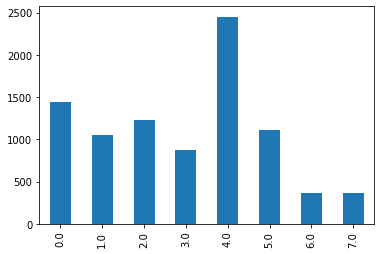

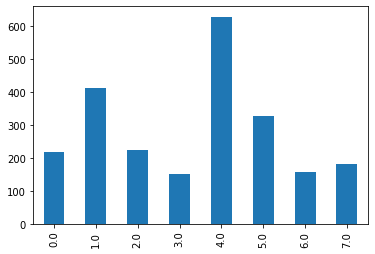

In [28]:
# Visualize the dataset

plt.figure()
df_metadata_train['label'].value_counts().sort_index().plot(kind='bar')

plt.figure()
df_metadata_test['label'].value_counts().sort_index().plot(kind='bar')

In [8]:
# Split training dataset to Train and Validation
df_metadata_train, df_metadata_valid = train_test_split(df_metadata_train,
                                       test_size = 0.1,
                                       random_state = 2018,
                                       stratify = df_metadata_train['label'],
                                       shuffle=True)

print("How many data for training:", df_metadata_train.shape[0])
print("How many data for validation:", df_metadata_valid.shape[0])
print("How many data for testing:", df_metadata_test.shape[0])

How many data for training: 8885
How many data for validation: 988
How many data for testing: 2309


## Helper functions for generating batches of 16 samples for training

In [9]:
# Reading images and prepare them for training
# - resizing the images and normalizing pixel values
def create_dataset(df):
   
    img_data_array=[]
    class_name=[]

    IMG_HEIGHT = IMG_WIDTH = 380
   
    for index, row in df.iterrows():
            image_path = IMAGES_DIR + 'images_original/aligned/' + row['image_path']
            label = row['label']

            my_file = Path(image_path)
            if my_file.is_file():
              image = cv2.imread(image_path, cv2.COLOR_BGR2RGB)
              image=cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)

              image=np.array(image)
              image = image.astype('float32')
              image /= 255 
              img_data_array.append(image)

              class_name.append(label)
   
    return np.array(img_data_array), np.array((class_name))

# Generate data in batches of 16 samples for training
def gen(df, batch_size=16):
    while True:
        steps = df.shape[0] // batch_size

        for i, df_batch in enumerate([df[i*batch_size:(i+1)*batch_size] for i in range(0, steps)]):
            X, Y = create_dataset(df_batch)
            yield X, Y

## Model

The model that we used as a base is the pretrained network (EfficientNet) and use only convolutional and pooling layers.
After that we added some BatchNormalization layers, max-pooling, dropout and two dense layers (one with 100 neurons and the final one with 8 neurons).



In [10]:
# Define how the model will look like

base_efficientnet_model = EfficientNetB4(input_shape =  (380, 380, 3), include_top = False, weights = 'imagenet')

age_model = Sequential()
age_model.add(BatchNormalization(input_shape =  (380, 380, 3)))
age_model.add(base_efficientnet_model)
age_model.add(BatchNormalization())
age_model.add(GlobalMaxPooling2D())
age_model.add(Dropout(0.5))
age_model.add(Dense(100, activation="relu"))
age_model.add(Dropout(0.5))
age_model.add(Dense(8, activation = 'softmax'))

## Training

The model is trained with batches of 16 samples and it is set to run on 100 epocs.
The loss we decided to use is "sparse categorical cross-entropy" and ADAM optimizer.

In [ ]:
# Training the model
age_model.compile(loss="sparse_categorical_crossentropy", metrics=['acc'], optimizer="adam")


weight_path = RESULTS_DIR + "age_recognition_weights_best.hdf5"
checkpoint = ModelCheckpoint(weight_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


# reducing learning rate
reduceLROnPlat = ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=3, mode="max")
early = EarlyStopping(monitor="val_acc",
                      mode="max",
                      patience=10)

tensorboard = TensorBoard(log_dir=RESULTS_DIR + "logs/{}".format(time()))
callbacks_list = [checkpoint, tensorboard, early, reduceLROnPlat]

age_model.fit_generator(gen(df_metadata_train),
                        validation_data = gen(df_metadata_valid),
                        epochs = 100,
                        callbacks = callbacks_list,
                        shuffle = True,
                        steps_per_epoch = df_metadata_train.shape[0] // 16,
                        validation_steps = df_metadata_valid.shape[0] // 16)


## Helper function for representing the confusion matrix


In [12]:
def plot_confusion_matrix(cm, classes, matrix_name, normalize=False, title='', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.

    Code is taken from scikit-learn.org example.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig = plt.figure("Confusion matrix")
    fig.set_size_inches(22, 22)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j, i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black"
        )

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    plt.show()

## Evaluation

In [ ]:
# Load the model with best weights
age_model = tf.keras.models.load_model(weight_path)

# Evaluation
X_test, Y_test = create_dataset(df_metadata_test)

results = age_model.evaluate(X_test, Y_test)
print("test loss, test acc:", results)


# Make some predictions on 16 images
predicted_classes = age_model.predict(X_test, batch_size=16)
predicted_classes = np.argmax(predicted_classes, axis=1)
actual_classes = Y_test

for i in range(16):
  image_path = IMAGES_DIR + 'images_original/aligned/' + df_metadata_test['image_path'][i]

  image_test = cv2.imread(image_path, cv2.COLOR_BGR2RGB)
  image_test = cv2.resize(image_test, (100, 100), interpolation = cv2.INTER_AREA)
  cv2_imshow(image_test)

  print("Prediction:", predicted_classes[i])
  print("Actual:", actual_classes[i])



Confusion matrix:

Confusion matrix, without normalization
[[  0   0   0   0 219   0   0   0]
 [  0   0   0   0 414   0   0   0]
 [  0   0   0   0 226   0   0   0]
 [  0   0   0   0 152   0   0   0]
 [  0   0   0   0 629   0   0   0]
 [  0   0   0   0 328   0   0   0]
 [  0   0   0   0 159   0   0   0]
 [  0   0   0   0 182   0   0   0]]


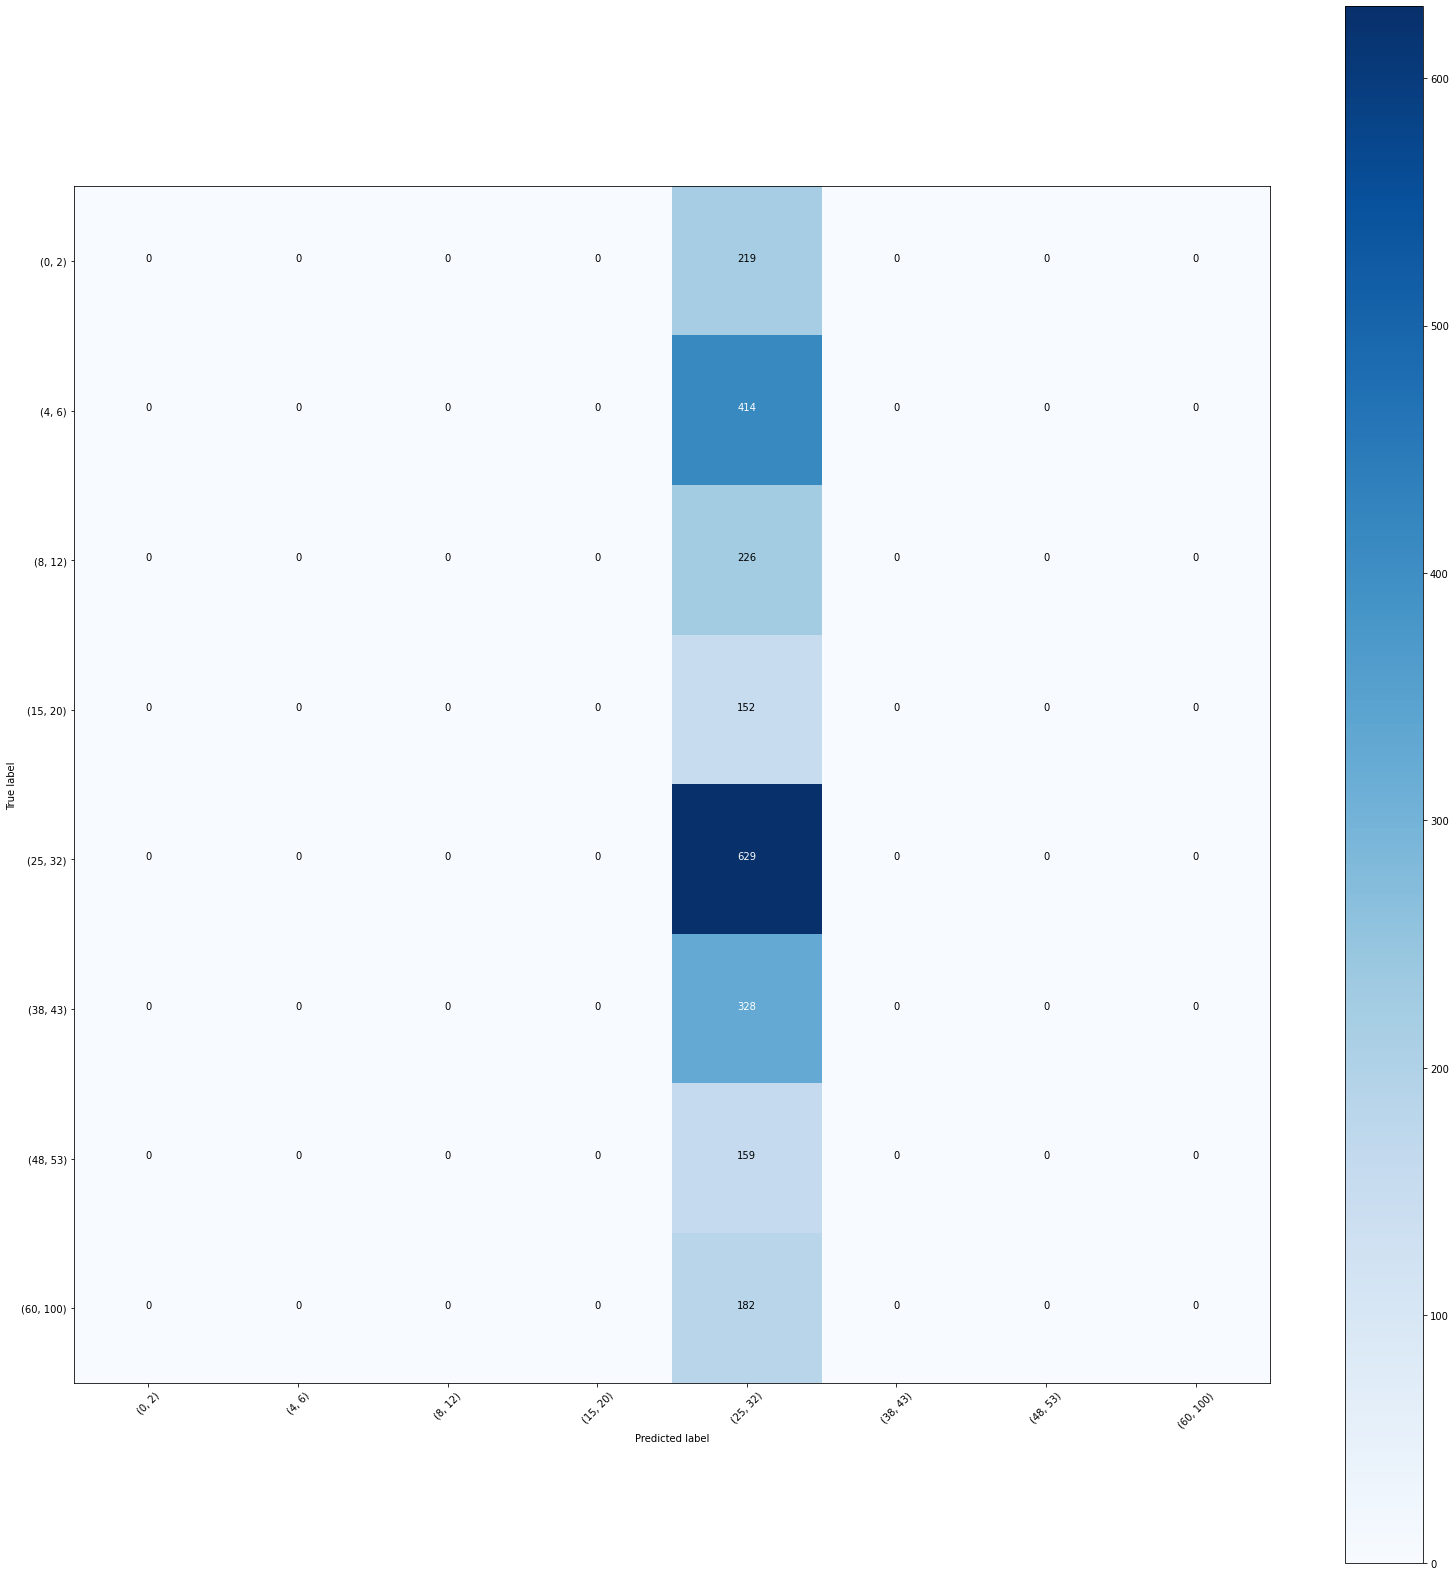

In [61]:
cm = confusion_matrix(actual_classes, predicted_classes)
plot_confusion_matrix(cm, LABEL_DICT.keys(), "CNN")

Classification report:


In [51]:
print('\nClassification Report\n')
print(classification_report(actual_classes, predicted_classes, target_names=LABEL_DICT.keys()))


Classification Report

              precision    recall  f1-score   support

      (0, 2)       0.00      0.00      0.00       219
      (4, 6)       0.00      0.00      0.00       414
     (8, 12)       0.00      0.00      0.00       226
    (15, 20)       0.00      0.00      0.00       152
    (25, 32)       0.27      1.00      0.43       629
    (38, 43)       0.00      0.00      0.00       328
    (48, 53)       0.00      0.00      0.00       159
   (60, 100)       0.00      0.00      0.00       182

    accuracy                           0.27      2309
   macro avg       0.03      0.12      0.05      2309
weighted avg       0.07      0.27      0.12      2309



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ROC curve:

ROC AUC score: 0.5


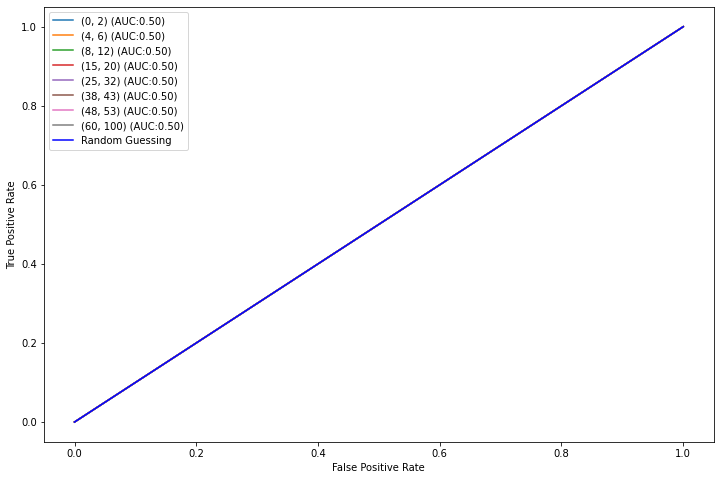

In [60]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(LABEL_DICT.keys()):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(actual_classes, predicted_classes))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()